In [1]:
"""
Script extracting wavenumbers, temperature, hot/cold status from temperature '.log' and raw spectra '.txt' files
"""
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import math as m
import pandas as pd
import glob
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import itertools
from scipy import interpolate
 
import csv

In [22]:
# VARIABLES

file_name = 'IC_raw_spectra_(2019_02_25_'

path_raw = 'H:/MSci Project/sand_outside' #path containing all raw spectra RACHEL
#path_raw = '/Users/micol/Documents/Imperial/Year4/Master_Project/sand_outside' #path containing all raw spectra
path_wns = 'H:/MSci Project'
file_path_tau = path_raw + "/Laura_simulations"
path_sensitivity = 'H:/MSci Project/Sensitivity_Analysis'

In [3]:
#FUNCTIONS

def read_file(directory, filename, separator, rowstoskip, head='infer'):
    """
    Reads an external file and outputs it as a Pandas Dataframe
    Input: Directory, Filename (Strings)
    Output: Pandas Dataframe
    """
    path=os.path.join(directory, filename)
    dataset = pd.read_csv(path, header = head, sep=separator, skiprows=rowstoskip)
    
    return dataset


def planck(wavenumber, temperature): # T in Kelvin, wavenumber in cm^-1
    """
    Calculates spectral radiance of a black body at some wavenumber and temperature
    Input: wavenumber (units: cm^{-1}), and temperature T (units: Kelvin) - (Integers or Floats)
    Output: spectral radiance (units: W m^{-2} sr^{-1} cm^{-1}) - (Float)
    """
    h = 6.626e-34
    c = 3.0e+8
    k = 1.381e-23

    planck_a = 2*h*(c**2)
    planck_e = h*c/k
    radiance = 100*planck_a*((wavenumber*100)**3)/(np.exp(planck_e*(wavenumber*100)/temperature)-1)

    return radiance


def read_raw_spectra(directory, filename):
    """
    Reads spectrum file and calculates the average of the 4 spectra
    Input: Directory, Filename (Strings)
    Output: average_spectrum (NumPy Array)
    """
    file_data = read_file(path_raw, filename, separator='  ', rowstoskip=5, head=None)
    spectrum1 = file_data[1].values
    spectrum2 = file_data[2].values
    spectrum3 = file_data[3].values
    spectrum4 = file_data[4].values
    
    return spectrum1,spectrum2,spectrum3,spectrum4

In [4]:
def inv_resp_function(hbb_spectrum, cbb_spectrum):
    
    V_diff = np.array(hbb_spectrum)-np.array(cbb_spectrum)
    
    temp_average_h = times_temps.at[hbb_index,'HBB_temp']
    temp_average_c = times_temps.at[cbb_index,'CBB_temp']

    radiances_avg_h = [planck(wn, float(temp_average_h)+273.15) for wn in wavenums_cut]
    radiances_avg_c = [planck(wn, float(temp_average_c)+273.15) for wn in wavenums_cut]
    rad_diff = np.array(radiances_avg_h) - np.array(radiances_avg_c)

    def division(raw_val,planck_val):
        if raw_val == 0:
            div = 0
        else:
            div = raw_val/planck_val
        return div

    division_vec = np.vectorize(division)
    ratio = division_vec(V_diff, rad_diff)

    return(ratio)


def plot_planck(t, wns):
    radiances = []
    for w in wns:
        radiances.append(planck(w, t+273.15))
    return radiances

In [5]:
#create list of file paths starting with file_name from 'path_raw' directory
measurements = len(glob.glob(path_raw + '/'+ file_name + '*')) #filepaths of all 'IC_raw_spectra' files
m_numbers = list(range(measurements)) #list of file name endings (integers)

for i in m_numbers:
    #checks that files have associated temperature measurements, and removes the files if not
    temp_check = read_file(path_raw, file_name + '{0:03}'.format(i) + '.txt', separator=',', rowstoskip=None, head=None).iloc[1,0]
    temp_check_float = float(temp_check.split()[0])
    if temp_check_float == 0.0:
        m_numbers.pop(i)

files = [file_name + '{0:03}'.format(num) + '.txt' for num in m_numbers][:-2] #final list of strings of file names, in order

In [6]:
columns_ = ['RT0','RT1','RT2','Dummy','RT3','RT4','HBB_temp','CBB_temp','Time', 'Orientation'] #columns for Pandas DataFrame

read_temps = []

for i in np.arange(0,len(files)):
    #Go through files and retrieve temperatures and orientations of spectra
    read_temps.append( read_file(path_raw, files[i], separator=',', rowstoskip=None, head=None).iloc[1:5,0].str.split() )
    read_temps_flat = list(itertools.chain(*read_temps)) #flatten read_temps_i

times_temps = pd.DataFrame(read_temps_flat, columns = columns_)

In [7]:
wavenums = read_file(path_raw, files[0], separator='  ', rowstoskip=5, head=None)[0].values

c:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


c:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


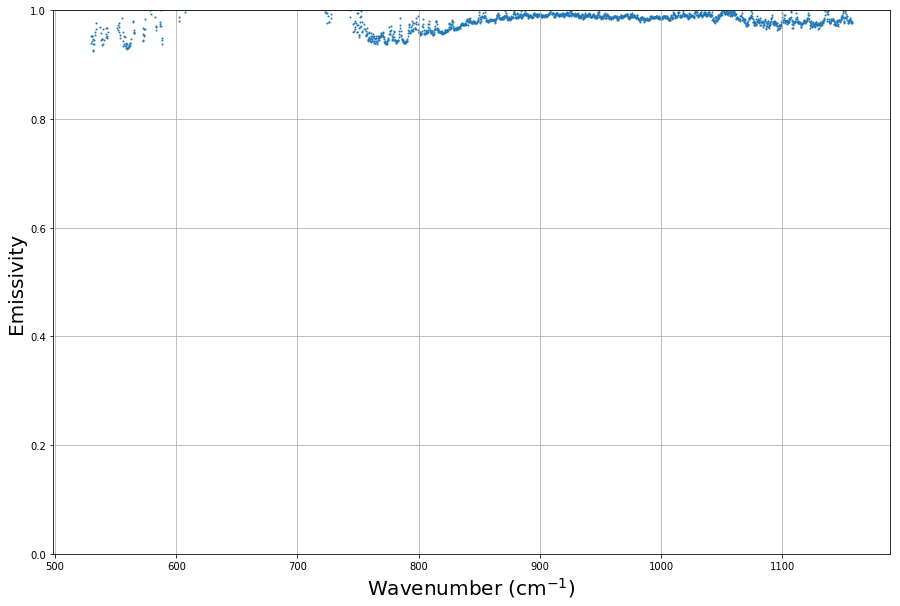

In [67]:
wavenums_cut = [wn for wn in wavenums if wn>400]
wavenums_min_ind = [i for i,x in enumerate(wavenums) if x >400][0]

plt.figure(figsize=(15,10))
all_ems = []

t_file = '2103_3063'
hbb_index = 528
cbb_index = 519
sky_index = 503
surface_index = 525
atm_t = 21.03
surf_t = 16.3
#time = '15:07'


hbb_spectrum = read_raw_spectra(path_raw, files[int(np.floor(hbb_index/4))])[hbb_index%4][wavenums_min_ind:]
cbb_spectrum = read_raw_spectra(path_raw, files[int(np.floor(cbb_index/4))])[cbb_index%4][wavenums_min_ind:]
response = inv_resp_function(hbb_spectrum, cbb_spectrum)

temp_average_h = times_temps.at[hbb_index,'HBB_temp']
radiances_avg_h = np.array([planck(wn, float(temp_average_h)+273.15) for wn in wavenums_cut])

sky = read_raw_spectra(path_raw, files[int(np.floor(sky_index/4))])[sky_index%4][wavenums_min_ind:]
surf = read_raw_spectra(path_raw, files[int(np.floor(surface_index/4))])[surface_index%4][wavenums_min_ind:]

sky_rad = np.divide((sky-hbb_spectrum), response) + radiances_avg_h
surf_rad = np.divide((surf-hbb_spectrum), response) + radiances_avg_h

tau_wn= []
taus_rtm = []
trans_file = np.loadtxt(file_path_tau + '/' + t_file +'.txt')
for i in np.arange(trans_file.shape[0]):
    tau_wn.append(trans_file[i][0])
    taus_rtm.append(trans_file[i][1])
f_trans = interpolate.interp1d(tau_wn, taus_rtm)

downs = []
ups = []
taus = []
wns =[]
for i in range(len(wavenums_cut)):
    if f_trans(wavenums_cut[i]) >0.98:
        taus.append(f_trans(wavenums_cut[i]))
        wns.append(wavenums_cut[i])
        downs.append(sky_rad[i])
        ups.append(surf_rad[i])

BBatm = plot_planck(atm_t, wns)
BBsurf = plot_planck(surf_t, wns)

N1 = np.array(ups)
N2 = np.array([t**2*d for t, d in zip(taus, downs)])
N3 = np.array([(1-t**2)*b for t, b in zip(taus, BBatm)])

N = N1-N2-N3

D1 = np.array([t*b for t, b in zip(taus, BBsurf)])
D2 = np.array([t**2*d for t, d in zip(taus, downs)])
D3 = np.array([t*(1-t)*b for t, b in zip(taus, BBatm)])

D = D1-D2-D3

emissivity = N/D

#plt.plot([min(wns), max(wns)], [1,1], 'k--')
plt.scatter(wns, emissivity, s=1)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.ylabel('Emissivity', fontsize=20)
plt.ylim([0,1])

plt.grid()
plt.show()

In [68]:
with open(os.path.join(path_sensitivity, 'Surf_T_' + str(surf_t) + '.csv'), "w") as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerows(zip(wns,emissivity))

In [70]:
a1 = read_file(path_sensitivity, 'Surf_T_17.1.csv', separator='\t', rowstoskip=None, head=None)
a2 = read_file(path_sensitivity, 'Surf_T_17.2.csv', separator='\t', rowstoskip=None, head=None)
a3 = read_file(path_sensitivity, 'Surf_T_17.3.csv', separator='\t', rowstoskip=None, head=None)
a4 = read_file(path_sensitivity, 'Surf_T_17.4.csv', separator='\t', rowstoskip=None, head=None)
a5 = read_file(path_sensitivity, 'Surf_T_17.5.csv', separator='\t', rowstoskip=None, head=None)
a18 = read_file(path_sensitivity, 'Surf_T_18.3.csv', separator='\t', rowstoskip=None, head=None)
a16 = read_file(path_sensitivity, 'Surf_T_16.3.csv', separator='\t', rowstoskip=None, head=None)

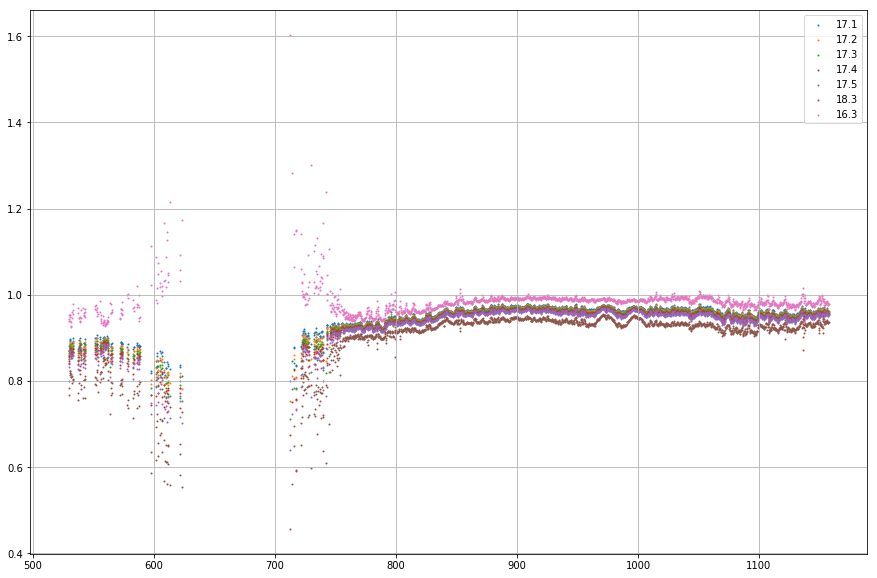

In [71]:
plt.figure(figsize=(15,10))
plt.scatter(a1[0],a1[1], s=1, label='17.1')
plt.scatter(a2[0],a2[1], s=1, label='17.2')
plt.scatter(a3[0],a3[1], s=1, label='17.3')
plt.scatter(a4[0],a4[1], s=1, label='17.4')
plt.scatter(a5[0],a5[1], s=1, label='17.5')
plt.scatter(a18[0],a18[1], s=1, label='18.3')
plt.scatter(a16[0],a16[1], s=1, label='16.3')

plt.legend()
#plt.ylim(0,1)
plt.grid()

TODO

#Corrrect emissivity equation

do with sand

see how stable emissivity is over time

if time, look at BB emissivity paper and incorporate that in our model. Take red line in figures 5,6 or interpolate between two 

see whether it has a big effect on emissivity - should see a jump around 1000 wavenums

uncertainyt in atm temp - what does it do to emissivity
uncertainty in transmittance - what does it do


Maybe plot our emissivities on top of Newman values. Maybe with uncertainties we are in the range
In the FIR look at FIR for sea water (maybe in supplementary materials). Emissivities went much lower? Difference is wiht salinity
Newman in FIR has not much effect of salinity 

Report: characterise instrument, e values and error analysis, comparison to previous papers

For errors:
     in the code estimate uncertainty in surface temperature, and put it in code keeping everything else constant - see effects of varyinf surf temp and same for all other components in the formula.